In [232]:
from pgmpy.models import BayesianNetwork, JunctionTree
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.models import MarkovNetwork
from pgmpy.inference import VariableElimination
import numpy as np
import pandas as pd

In [233]:
alarm_model = BayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_burglary = TabularCPD(
    variable="Burglary", variable_card=2, values=[[0.999], [0.001]]
)
cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998], [0.002]]
)
cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[[0.999, 0.71, 0.06, 0.05], [0.001, 0.29, 0.94, 0.95]],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)
cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)
cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[[0.1, 0.7], [0.9, 0.3]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls)

In [234]:
import random
from itertools import product

def initialize(evidence, model):
    
    #Iniciamos con una variable aleatoria la forward local search
    #Elijo la variable aleatoriamente
    variables=list(set(model.nodes())-set(list(evidence.keys())))
    rIndex = random.randrange(len(variables))
    rVar=variables[rIndex]
    #Elijo el estado de esa variable aleatoriamente
    rIndex = random.randrange(len(model.states[rVar]))
    rVarState=model.states[rVar][rIndex]
    state=dict()
    state[rVar]=rVarState
    print('state y rVar', state, rVar)

    return state, rVar

def neighbors_add(state, variables, model):
    neigh=[]
    for i in range(len(variables)):
        name=variables[i]
        
        for j in range(len(model.states[name])):
            rVarState=model.states[name][j]
            neigh.append({**state, **{name:rVarState}})
   
    return neigh
            

def neighbors_change(state, model):
    neigh_add=[]
    for i in state.keys():

        for j in model.states[i]:
            
            #if int(j)!=int(state[i]):
            if j!=state[i]:    
                state_aux=state.copy()
                state_aux[i]=j
                neigh_add.append(state_aux.copy())
 
    return neigh_add

def GBF(dict_query, evidence, model):
  
    array1=[model.states[i] for i in dict_query.keys()]
   
    combinations=[]
    for elem in product(*array1):
        combinations.append(elem)
    #En las tablas de las queries aparecen todas las posibles combinaciones
    index=tuple(list(dict_query.values()))
    posiciones = combinations.index(index)
    
    inference = VariableElimination(model)
   
    phi_query1=inference.query(dict_query, evidence=evidence)
    phi_query2=inference.query(dict_query)
    # print(phi_query1, phi_query2)


    flat_list1=phi_query1.values.flatten()
    flat_list2=phi_query2.values.flatten()
    probab1=flat_list1[posiciones]
    probab2=flat_list2[posiciones]
    
    gbf=(probab1*(1-probab2))/(probab2*(1-probab1))
    return gbf



def get_MRE(neigh1, neigh2,evidence, model):
    
    best=neigh2[0]
    best_gbf=GBF(neigh2[0], evidence, model)
   
    for i in neigh1:
        a=GBF(i, evidence, model)
        
        if a>best_gbf:
            best=i
            best_gbf=a
    
    for i in neigh2:
        a=GBF(i, evidence,model)
        
        if a>best_gbf:
            best=i
            best_gbf=a
    return best, best_gbf

def strong_dom(dict1, df,gbf):
    for s1 in range(len(df)):
           
        if not all(((j in dict1) and df.iloc[s1]['Explanations'][j]==dict1[j] and gbf<=df.iloc[s1]['GBF']) for j in df.iloc[s1]['Explanations']):
            #print('el candidato no esta dominado por esta instancia del dataframe existente')
            return False
        else:
             print('El siguiente candidato será rechazado por estar dominado fuertemente')
             print('dataframe', df.iloc[s1]['Explanations'], 'gbf', df.iloc[s1]['GBF'])
             print('dict', dict1, 'gbf', gbf)
             return True
        
def weak_dom(dict1, df,gbf):
    for s1 in range(len(df)):
           
        if not all(((j in df.iloc[s1]['Explanations']) and df.iloc[s1]['Explanations'][j]==dict1[j] and gbf<=df.iloc[s1]['GBF']) for j in dict1):
            #print('el candidato no esta debilment dominado por esta instancia del dataframe existente')
            return False
        else:
            # print('dataframe', df.iloc[s1]['Explanations'], 'gbf', df.iloc[s1]['GBF'])
            # print('dict', dict1, 'gbf', gbf)
            return True
                
def strong_dom2(dict1, dict2, gbf1, gbf2):

    if all(key in dict1 and dict1[key] == dict2[key] for key in dict2) and gbf2>=gbf1:
        #print("diccionario2 está contenido en diccionario1")
        return True
    else:
        return False

def weak_dom2(dict1, dict2, gbf1, gbf2):

    if all(key in dict2 and dict2[key] == dict1[key] for key in dict1) and gbf2>=gbf1:
        
        return True
    else:
        return False 


evidence={'MaryCalls':0}
dead_iter=2
inference = VariableElimination(alarm_model)
kMRE=[]
kGBF=[]
kdf=pd.DataFrame()
kdf['Explanations']=None
kdf['GBF']=None


    

    

    

In [235]:

from pgmpy.inference import VariableElimination
belief_propagation = VariableElimination(alarm_model)
belief_propagation.map_query(evidence={'MaryCalls':0},variables=['Earthquake'])



Eliminating: Alarm: 100%|██████████| 2/2 [00:00<00:00, 400.28it/s]


{'Earthquake': 0}

In [236]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.models import BayesianModel
import pandas as pd
import networkx as nx
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import networkx as nx
from sklearn.preprocessing import KBinsDiscretizer
df = pd.read_csv('COVID-19_real_discrete_discretised_quartiles.csv')
df.drop(['Season', 'Transportation_activity','Face_masks', 'Lockdown', 'Work_and_school_activity', 'Majority_COVID_19_variant', 'Leisure_activity'], axis=1, inplace=True)
df2 = pd.read_csv('COVID-19_real_continuous.csv')
df2.drop(['Season', 'Transportation_activity','Face_masks', 'Lockdown', 'Work_and_school_activity', 'Majority_COVID_19_variant', 'Leisure_activity'], axis=1, inplace=True)
#print(df2.describe())
df2.describe().to_csv('examplecovid.csv')

scoring_method = K2Score(data=df)
est = HillClimbSearch(data=df)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
print(estimated_model.edges)

model = BayesianNetwork(estimated_model.edges)
model.fit(df, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5

evidence={'Second_dose_uptake':'Low', 'Excess_mortality': 'High'}
dead_iter=5
inference = VariableElimination(model)
kMRE=[]
kGBF=[]
kdf=pd.DataFrame()
kdf['Explanations']=None
kdf['GBF']=None

for l in range(5):
    state, rVar=initialize(evidence, model)

    not_better = 0
    for k in range(10):
        
        if k==0:
            xlocbest=state
            gbflocal=GBF(state, evidence, model)
            
        variables=list(model.nodes())
        variables = list((set(variables)-set(list(evidence.keys())))-set(list(xlocbest.keys())))

        neigh1=neighbors_add(xlocbest, variables=variables, model=model)
        neigh2=neighbors_change(xlocbest, model)
        
        state, best_gbf=get_MRE(neigh1, neigh2,evidence, model)
        if best_gbf>gbflocal:
            xlocbest=state
            gbflocal=best_gbf
        else:
            not_better += 1
            if not_better == dead_iter:
                kMRE.append(xlocbest)
                kGBF.append(gbflocal)
                break
        kMRE.append(xlocbest)
        kGBF.append(gbflocal)
poolMRE=[]

for i in range(len(kMRE)):
    
    if len(kdf)==0:
        df2=pd.DataFrame({'Explanations':[kMRE[i]], 'GBF':kGBF[i]})
        kdf=pd.concat([kdf,df2], ignore_index=True)

    else:

        if kGBF[i]>kdf['GBF'].min() and not(strong_dom(kMRE[i], kdf, kGBF[i])) and not(weak_dom(kMRE[i], kdf, kGBF[i])) :
            df2=pd.DataFrame({'Explanations':[kMRE[i]], 'GBF':kGBF[i]})
            kdf=pd.concat([kdf,df2], ignore_index=True)
          
            
rows_to_remove = []
for i in range(len(kdf)):
    current_row = kdf.iloc[i]
    for j in range(i + 1, len(kdf)):
       
        if strong_dom2(current_row['Explanations'],kdf.iloc[j]['Explanations'], current_row['GBF'], kdf.iloc[j]['GBF']) or weak_dom2(current_row['Explanations'],kdf.iloc[j]['Explanations'], current_row['GBF'], kdf.iloc[j]['GBF']):
            rows_to_remove.append(i)

df_filtered = kdf.drop(rows_to_remove) 
df_filtered.to_csv('datos_covid_filtered.txt', sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ")


  0%|          | 23/10000 [00:03<27:39,  6.01it/s] 


[('Positive_tests', 'New_infections'), ('Positive_tests', 'Tests_across_all_4_Pillars'), ('Positive_tests', 'Hospital_admissions'), ('Positive_tests', 'Deaths_with_COVID_on_certificate'), ('Tests_across_all_4_Pillars', 'Excess_mortality'), ('Deaths_with_COVID_on_certificate', 'Patients_in_MVBs'), ('Reinfections', 'Positive_tests'), ('Reinfections', 'Hospital_admissions'), ('Reinfections', 'Patients_in_MVBs'), ('Reinfections', 'Deaths_with_COVID_on_certificate'), ('Reinfections', 'Tests_across_all_4_Pillars'), ('Patients_in_MVBs', 'Excess_mortality'), ('Hospital_admissions', 'Patients_in_hospital'), ('Hospital_admissions', 'Tests_across_all_4_Pillars'), ('Hospital_admissions', 'Excess_mortality'), ('Second_dose_uptake', 'Tests_across_all_4_Pillars'), ('Second_dose_uptake', 'Patients_in_MVBs'), ('Second_dose_uptake', 'Deaths_with_COVID_on_certificate'), ('Patients_in_hospital', 'Deaths_with_COVID_on_certificate'), ('Patients_in_hospital', 'Second_dose_uptake'), ('Patients_in_hospital', '

In [237]:
from pgmpy.inference import VariableElimination
belief_propagation = VariableElimination(model)
belief_propagation.map_query(variables=['Positive_tests' , 'Tests_across_all_4_Pillars','Deaths_with_COVID_on_certificate' , 'Reinfections',  'Patients_in_MVBs', 'Hospital_admissions'  , 'Patients_in_hospital', 'New_infections' ],evidence=evidence)
#belief_propagation.map_query(variables=['Deaths_with_COVID_on_certificate' , 'Reinfections',  'Patients_in_MVBs', 'Patients_in_hospital'], evidence=evidence)


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]


{'Positive_tests': 'Very Low',
 'Tests_across_all_4_Pillars': 'Very High',
 'Deaths_with_COVID_on_certificate': 'Very Low',
 'Reinfections': 'Very Low',
 'Patients_in_MVBs': 'Very Low',
 'Hospital_admissions': 'Low',
 'Patients_in_hospital': 'Very Low',
 'New_infections': 'Very Low'}

In [238]:

import csv

kdf.to_csv('datos_covid.txt', sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ")
display(kdf['Explanations'])


0     {'Patients_in_MVBs': 'Very Low', 'Hospital_adm...
1     {'Patients_in_MVBs': 'Very Low', 'Hospital_adm...
2     {'Patients_in_MVBs': 'High', 'Hospital_admissi...
3     {'Patients_in_MVBs': 'High', 'Hospital_admissi...
4     {'Patients_in_MVBs': 'High', 'Hospital_admissi...
5     {'Patients_in_MVBs': 'High', 'Hospital_admissi...
6     {'Patients_in_MVBs': 'High', 'Hospital_admissi...
7     {'Patients_in_MVBs': 'Very High', 'Hospital_ad...
8     {'Patients_in_MVBs': 'Very High', 'Hospital_ad...
9     {'Patients_in_MVBs': 'Very High', 'Hospital_ad...
10    {'Patients_in_hospital': 'Very Low', 'New_infe...
11    {'Patients_in_hospital': 'Very Low', 'New_infe...
12    {'Patients_in_hospital': 'Very Low', 'New_infe...
13    {'Patients_in_hospital': 'Very Low', 'New_infe...
14    {'Patients_in_hospital': 'Very High', 'New_inf...
15    {'Patients_in_hospital': 'Very High', 'New_inf...
16    {'Patients_in_hospital': 'Low', 'New_infection...
17    {'Patients_in_hospital': 'Low', 'New_infec

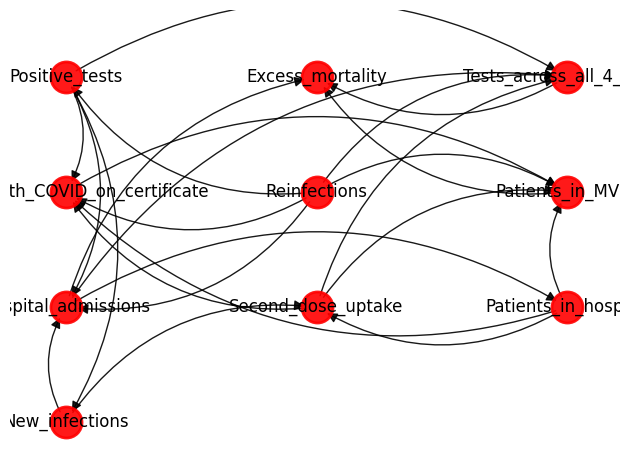

In [239]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt




def _set_positions(variables: list) -> dict:
    n_variables = len(variables)
    n_cols = int(np.sqrt(n_variables))
    n_rows = int(np.ceil(n_variables / n_cols))

    pos_list = []
    for row in range(n_rows):
        for col in range(n_cols):
            pos_list.append([col, -row])



    return {variables[i]: pos_list[i] for i in range(n_variables)}


def plot_bn(arcs: list, var_names: list, pos: dict = None, curved_arcs: bool = True,
            curvature: float = -0.3, node_size: int = 500, node_color: str = 'red',
            edge_color: str = 'black', arrow_size: int = 15, node_transparency: float = 0.9,
            edge_transparency: float = 0.9, node_line_widths: float = 2, title: str = None,
            output_file: str = None):
    """
    This function Plots a BN structure as a directed acyclic graph.

    :param arcs: Arcs in the BN structure.
    :param var_names: List of variables.
    :param pos: Positions in the plot for each node.
    :param curved_arcs: True if curved arcs are desired.
    :param curvature: Radians of curvature for edges. By default, -0.3.
    :param node_size: Size of the nodes in the graph. By default, 500.
    :param node_color: Color set to nodes. By default, 'red'.
    :param edge_color: Color set to edges. By default, 'black'.
    :param arrow_size: Size of arrows in edges. By default, 15.
    :param node_transparency: Alpha value [0, 1] that defines the transparency of the node. By default, 0.9.
    :param edge_transparency: Alpha value [0, 1] that defines the transparency of the edge. By default, 0.9.
    :param node_line_widths: Width of the nodes contour lines. By default, 2.0.
    :param title: Title for Figure. By default, None.
    :param output_file: Path to save the figure locally.
    :type arcs: list(tuple)
    :type var_names: list
    :type pos: dict {name of variables: tuples with coordinates}
    :type curved_arcs: bool
    :type curvature: float
    :type node_size: int
    :type node_color: str
    :type edge_color: str
    :type arrow_size: int
    :type node_transparency: float
    :type edge_transparency: float
    :type node_line_widths: float
    :type title: str
    :type output_file: str
    :return: Figure.
    """

    g = nx.DiGraph()
    g.add_nodes_from(var_names)
    g.add_edges_from(arcs)

    if not pos:
        pos = _set_positions(var_names)

    nx.draw_networkx_nodes(g, pos, node_size=node_size, node_color=node_color, alpha=node_transparency,
                           linewidths=node_line_widths)

    if curved_arcs:
        nx.draw_networkx_edges(g, pos, edgelist=g.edges(), edge_color=edge_color,
                               connectionstyle="arc3,rad=" + str(curvature), arrowsize=arrow_size,
                               alpha=edge_transparency)
    else:
        nx.draw_networkx_edges(g, pos, edgelist=g.edges(), edge_color=edge_color, arrowsize=arrow_size)

    nx.draw_networkx_labels(g, pos)

    plt.axis('off')
    if title:
        plt.title(title)
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file)

    plt.show()


plot_bn(arcs=estimated_model.edges,var_names=list(estimated_model.nodes),pos=None)

In [240]:
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
df = pd.read_csv('measures_v2.csv')
df2=df.loc[df['profile_id']==17]
df2.drop(['u_q', 'u_d','i_d','i_q','profile_id'], axis=1, inplace=True)



df2.describe().to_csv('quartiles_motor.csv')
for i in df2.columns:
    
    
    df2[i+' cut'] = pd.qcut(df2[i], q=4,
                      labels=['Very Low', 'Low', 'High', 'Very high'])
    df2.drop([i], axis=1, inplace=True)
print(df2)

scoring_method = K2Score(data=df2)
est = HillClimbSearch(data=df2)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
print(estimated_model.edges)

model = BayesianNetwork(estimated_model.edges)
model.fit(df2, estimator=BayesianEstimator, prior_type="BDeu") 



C:\Users\Marta\AppData\Local\Temp\ipykernel_9000\1202764999.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['u_q', 'u_d','i_d','i_q','profile_id'], axis=1, inplace=True)
C:\Users\Marta\AppData\Local\Temp\ipykernel_9000\1202764999.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[i+' cut'] = pd.qcut(df2[i], q=4,
C:\Users\Marta\AppData\Local\Temp\ipykernel_9000\1202764999.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

      coolant cut stator_winding cut stator_tooth cut motor_speed cut  \
0             Low           Very Low         Very Low        Very Low   
1             Low           Very Low         Very Low        Very Low   
2             Low           Very Low         Very Low        Very Low   
3             Low           Very Low         Very Low        Very Low   
4             Low           Very Low         Very Low        Very Low   
...           ...                ...              ...             ...   
15959    Very Low           Very Low         Very Low             Low   
15960    Very Low           Very Low         Very Low        Very Low   
15961    Very Low           Very Low         Very Low             Low   
15962    Very Low           Very Low         Very Low        Very Low   
15963    Very Low           Very Low         Very Low        Very Low   

         pm cut stator_yoke cut ambient cut torque cut  
0      Very Low        Very Low    Very Low        Low  
1      Ve

  0%|          | 20/10000 [00:01<16:06, 10.33it/s] 


[('stator_winding cut', 'stator_tooth cut'), ('stator_winding cut', 'torque cut'), ('stator_winding cut', 'ambient cut'), ('stator_winding cut', 'pm cut'), ('stator_winding cut', 'coolant cut'), ('stator_winding cut', 'stator_yoke cut'), ('stator_tooth cut', 'stator_yoke cut'), ('motor_speed cut', 'stator_winding cut'), ('motor_speed cut', 'ambient cut'), ('motor_speed cut', 'pm cut'), ('pm cut', 'ambient cut'), ('pm cut', 'stator_yoke cut'), ('pm cut', 'coolant cut'), ('pm cut', 'stator_tooth cut'), ('pm cut', 'torque cut'), ('stator_yoke cut', 'coolant cut'), ('stator_yoke cut', 'ambient cut'), ('ambient cut', 'torque cut'), ('ambient cut', 'coolant cut')]


In [241]:
evidence={'coolant cut':'Low', 'torque cut': 'Low'}
dead_iter=2
inference = VariableElimination(model)
kMRE=[]
kGBF=[]
kdf=pd.DataFrame()
kdf['Explanations']=None
kdf['GBF']=None

for l in range(2):
    state, rVar=initialize(evidence, model)
    # print('initial state', state)


    not_better = 0
    for k in range(5):
        
        if k==0:
            xlocbest=state
            gbflocal=GBF(state, evidence, model)
            
        variables=list(model.nodes())
        variables = list((set(variables)-set(list(evidence.keys())))-set(list(xlocbest.keys())))

        neigh1=neighbors_add(xlocbest, variables=variables, model=model)
        neigh2=neighbors_change(xlocbest, model)
        
        state, best_gbf=get_MRE(neigh1, neigh2,evidence, model)
        if best_gbf>gbflocal:
            xlocbest=state
            gbflocal=best_gbf
        else:
            not_better += 1
            if not_better == dead_iter:
                kMRE.append(xlocbest)
                kGBF.append(gbflocal)
                break
        kMRE.append(xlocbest)
        kGBF.append(gbflocal)
poolMRE=[]
for i in range(len(kMRE)):
    
    if len(kdf)==0:
        df2=pd.DataFrame({'Explanations':[kMRE[i]], 'GBF':kGBF[i]})
        kdf=pd.concat([kdf,df2], ignore_index=True)
        kGBFi=kGBF[i]
        kMREi=kMRE[i]


    else:

        if kGBF[i]>kdf['GBF'].min() and not(strong_dom(kMRE[i], kdf, kGBF[i])) and not(weak_dom(kMRE[i], kdf, kGBF[i])) :
        
            df2=pd.DataFrame({'Explanations':[kMRE[i]], 'GBF':kGBF[i]})
            kdf=pd.concat([kdf,df2], ignore_index=True)
            kGBFi=kGBF[i]
            kMREi=kMRE[i]

 

# we then need to check whether there are existing top explanations that are dominated by the newly added explanation

rows_to_remove = []
for i in range(len(kdf)):
    current_row = kdf.iloc[i]
    for j in range(i + 1, len(kdf)):
       
        if strong_dom2(current_row['Explanations'],kdf.iloc[j]['Explanations'], current_row['GBF'], kdf.iloc[j]['GBF']) or weak_dom2(current_row['Explanations'],kdf.iloc[j]['Explanations'], current_row['GBF'], kdf.iloc[j]['GBF']):
            rows_to_remove.append(i)

df_filtered = kdf.drop(rows_to_remove)
                    
df_filtered.to_csv('datos_motor_filtered.txt', sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ")



            

state y rVar {'motor_speed cut': 'Very Low'} motor_speed cut
state y rVar {'pm cut': 'Low'} pm cut


In [242]:

kdf.to_csv('datos_motor.txt', sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ")
display(kdf['Explanations'])

0    {'motor_speed cut': 'Very Low', 'stator_windin...
1    {'motor_speed cut': 'Very Low', 'stator_windin...
2    {'motor_speed cut': 'Very high', 'stator_windi...
3    {'motor_speed cut': 'Very high', 'stator_windi...
4    {'motor_speed cut': 'Very high', 'stator_windi...
5                               {'pm cut': 'Very Low'}
6    {'pm cut': 'Very Low', 'stator_winding cut': '...
7    {'pm cut': 'Very Low', 'stator_winding cut': '...
8    {'pm cut': 'Very Low', 'stator_winding cut': '...
9    {'pm cut': 'Very Low', 'stator_winding cut': '...
Name: Explanations, dtype: object

In [243]:
from pgmpy.inference import VariableElimination
belief_propagation = VariableElimination(model)
belief_propagation.map_query(evidence={'coolant cut':'Low', 'torque cut': 'Low'})
#belief_propagation.map_query(variables=['Deaths_with_COVID_on_certificate' , 'Reinfections',  'Patients_in_MVBs', 'Patients_in_hospital'], evidence=evidence)


{'ambient cut': 'Very Low',
 'motor_speed cut': 'Very high',
 'torque cut': 'High',
 'pm cut': 'High',
 'stator_tooth cut': 'High',
 'stator_yoke cut': 'High',
 'coolant cut': 'Very high',
 'stator_winding cut': 'High'}